In [1]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import time

from mrcnn.visualize import display_instances, display_top_masks
from mrcnn.utils import extract_bboxes

from mrcnn.utils import Dataset
from matplotlib import pyplot as plt

from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn import visualize

from mrcnn import model as modellib, utils
from PIL import Image, ImageDraw

Using TensorFlow backend.


In [2]:
EPOCHS = [1,50]

In [3]:
class CocoLikeDataset(utils.Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """
    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            
            self.add_class(source_name, class_id, class_name)
        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
                
    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

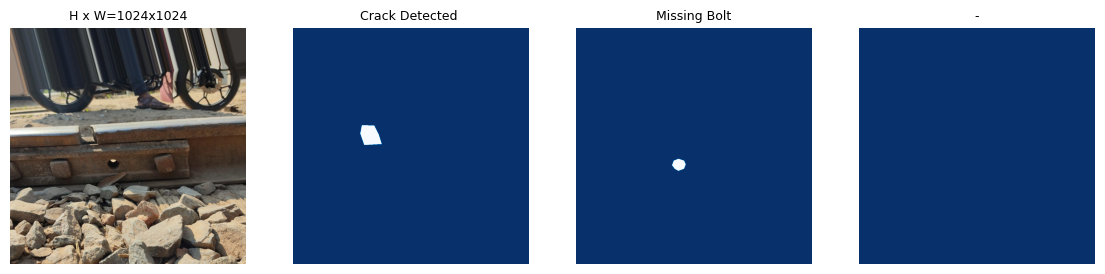

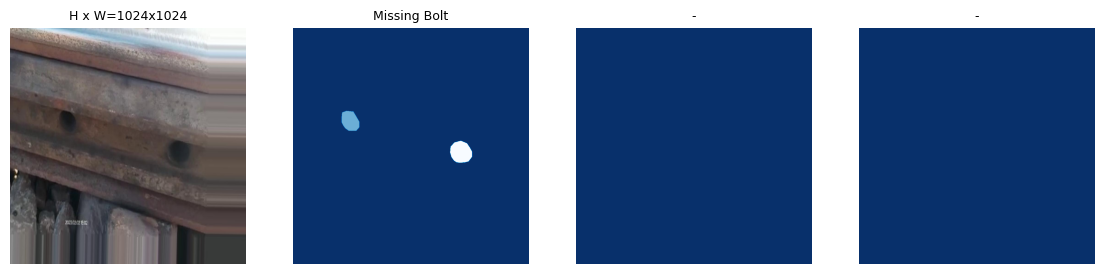

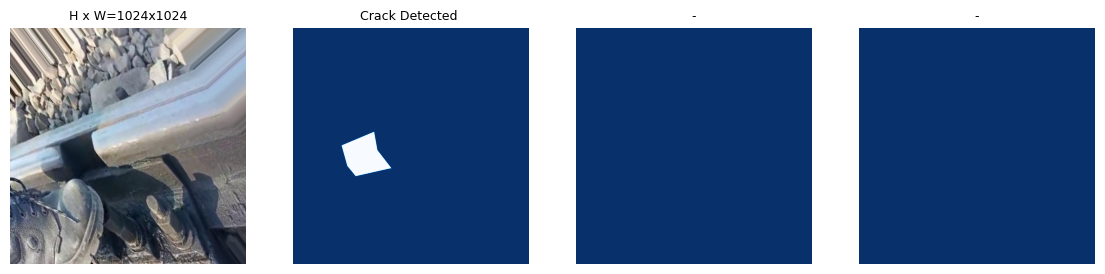

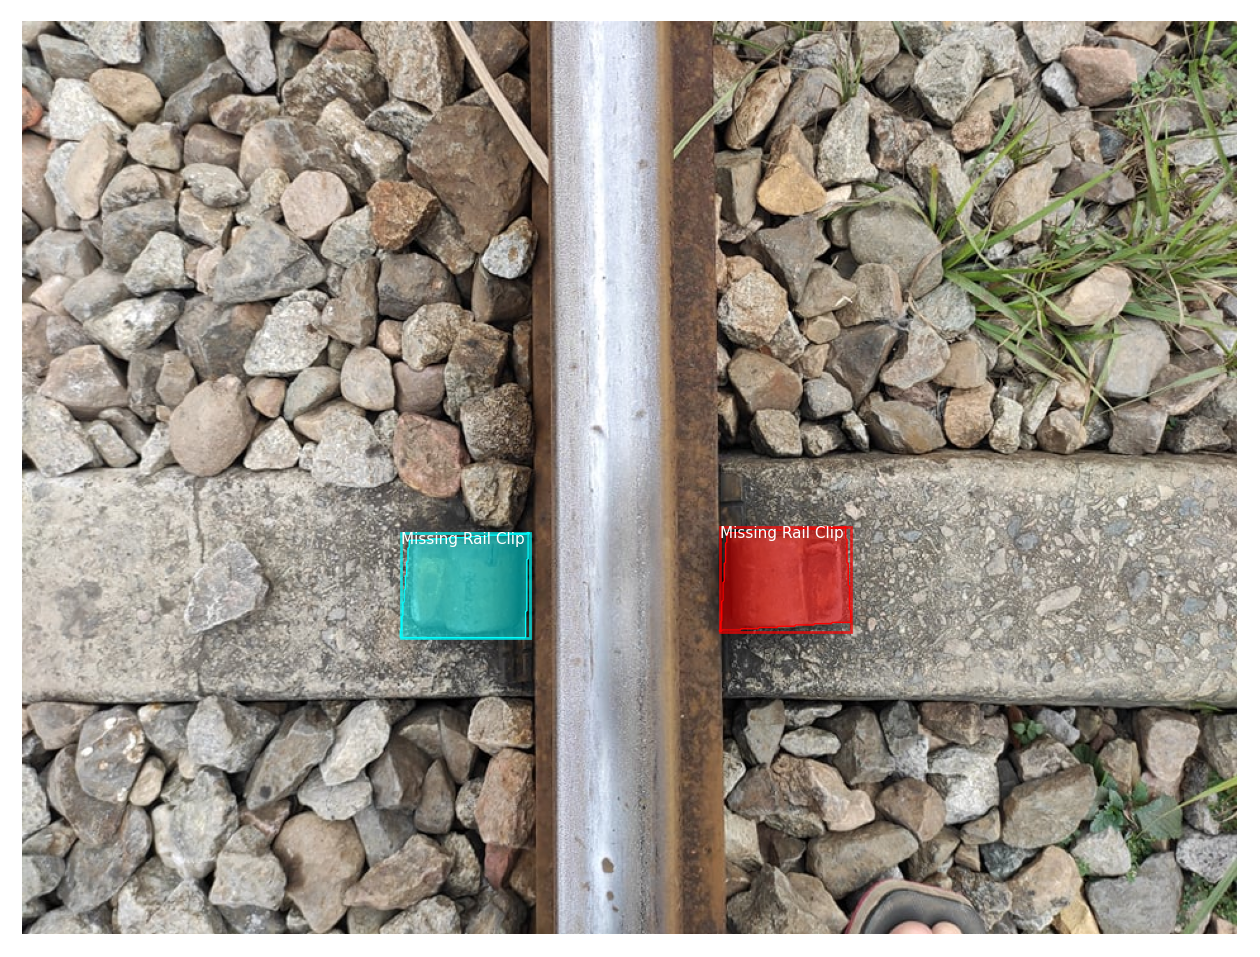


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [4]:
dataset_train = CocoLikeDataset()
dataset_train.load_data('dataset/Annotation 1900.json', 'dataset/Train')
dataset_train.prepare()

#In this example, I do not have annotations for my validation data, so I am loading train data
dataset_val = CocoLikeDataset()
dataset_val.load_data('dataset/coco new train.json', 'dataset/validation169')
dataset_val.prepare()


dataset = dataset_train
image_ids = dataset.image_ids
image_ids = np.random.choice(dataset.image_ids, 3)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    display_top_masks(image, mask, class_ids, dataset.class_names, limit=3)  #limit to total number of classes



# define image id
image_id = 0
# load the image
image = dataset_train.load_image(image_id)
# load the masks and the class ids
mask, class_ids = dataset_train.load_mask(image_id)

# display_instances(image, r1['rois'], r1['masks'], r1['class_ids'],
# dataset.class_names, r1['scores'], ax=ax, title="Predictions1")

# extract bounding boxes from the masks
bbox = extract_bboxes(mask)
# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, dataset_train.class_names)


# define a configuration for the model
class MarbleConfig(Config):
	# define the name of the configuration
	NAME = "marble_cfg_coco"
	# number of classes (background + blue marble + non-Blue marble)
	NUM_CLASSES = 1 + 3
	# number of training steps per epoch
	STEPS_PER_EPOCH = 100
    #DETECTION_MIN_CONFIDENCE = 0.9 # Skip detections with < 90% confidence
# prepare config
config = MarbleConfig()
config.display()

In [5]:
ROOT_DIR = os.path.abspath("./")
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
# Directory to save logs and trained model
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")
# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

In [6]:
########################
#Weights are saved to root directory.
#saved to the directory defined... "logs_models"
###############

# define the model
model = MaskRCNN(mode='training', model_dir=DEFAULT_LOGS_DIR, config=config)
# load weights (mscoco) and exclude the output layers
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

In [7]:
model.keras_model.summary()

Model: "mask_rcnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________

In [ ]:
# # train weights (output layers or 'heads')
model.train(dataset_train, dataset_val, learning_rate=config.LEARNING_RATE, epochs=EPOCHS[0], layers='heads')

history = model.keras_model.history.history

In [ ]:
# # train weights (output layers or 'heads')
model.train(dataset_train, dataset_val, learning_rate=config.LEARNING_RATE, epochs=EPOCHS[1], layers='heads')

new_history = model.keras_model.history.history

for k in new_history:
    history[k] = history[k] + new_history[k]+

In [ ]:
# epochs = range(EPOCHS[-1])
epochs = np.arange(1, len(history['loss'])+1)
plt.figure(figsize=(10, 8))

plt.subplot(131)
plt.plot(epochs, history['loss'], label="train loss")
plt.plot(epochs, history['val_loss'], label="valid loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss Curves')
plt.legend()
plt.subplot(132)
plt.plot(epochs, history['mrcnn_class_loss'], label="train class loss")
plt.plot(epochs, history['val_mrcnn_class_loss'], label="valid class loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation class Loss Curves')
plt.legend()
plt.subplot(133)
plt.plot(epochs, history['mrcnn_mask_loss'], label="train mask loss")
plt.plot(epochs, history['val_mrcnn_mask_loss'], label="valid mask loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation class mask Loss Curves')
plt.legend()


plt.show()


In [ ]:
best_epoch = np.argmin(history["val_loss"][1:]) + 1
print("Best epoch: ", best_epoch)
print("Valid loss: ", history["val_loss"][1:][best_epoch-1])

In [8]:
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from mrcnn.utils import compute_ap
from numpy import expand_dims
from numpy import mean
from matplotlib.patches import Rectangle

In [9]:
# define the prediction configuration
class PredictionConfig(Config):
    # define the name of the configuration
    NAME = "marble_cfg_coco"
    # number of classes (background + Blue Marbles + Non Blue marbles)
    NUM_CLASSES = 1 + 3
    # Set batch size to 1 since we'll be running inference on
            # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    BATCH_SIZE = 1
    IMAGES_PER_GPU = 1

In [10]:
# create config
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='logs', config=cfg)
# load model weights
model.load_weights('logs/marble_cfg_coco20230507T1731/mask_rcnn_marble_cfg_coco_0049.h5', by_name=True)


Re-starting from epoch 49


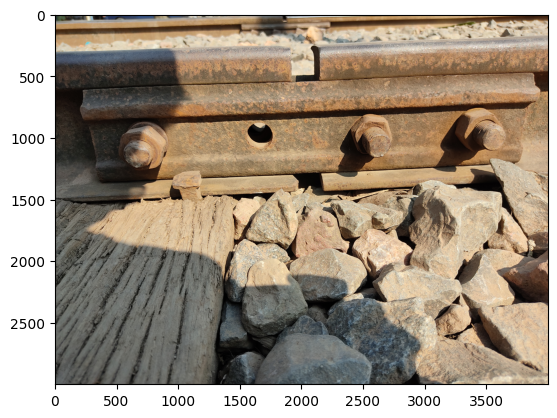

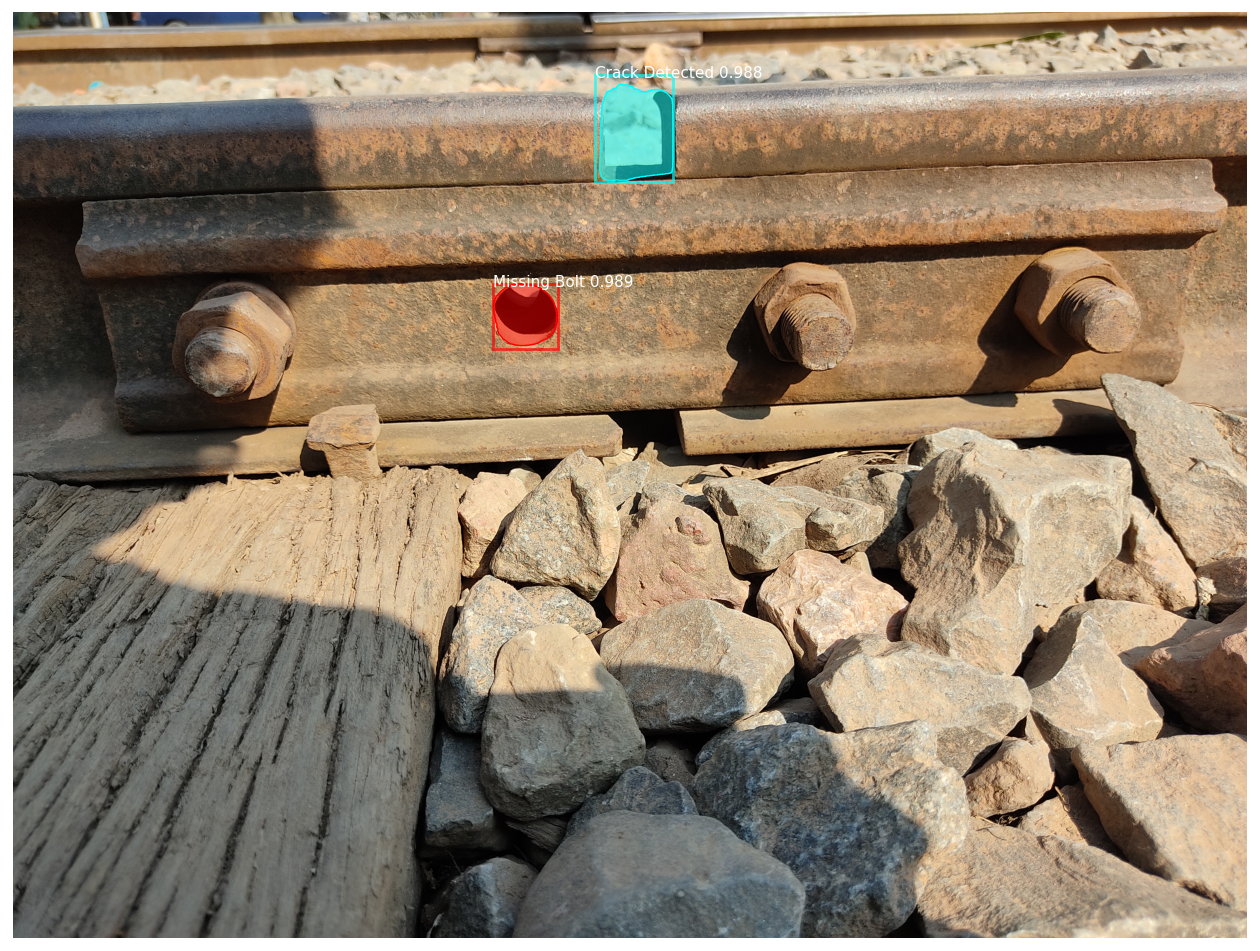

In [11]:
#Test on a single image
marbles_img = skimage.io.imread('dataset/Train/IMG_20201114_101149.jpg')
plt.imshow(marbles_img)

detected = model.detect([marbles_img])
results = detected[0]
class_names = ['BG', 'Missing Rail Clip', 'Missing Bolt','Crack Detected']
display_instances(marbles_img, results['rois'], results['masks'], 
                  results['class_ids'], class_names, results['scores'])


In [12]:
print("Number of images:", len(detected), end="\n\n")
print("Bounding Boxes:\n", results['rois'], end="\n\n")
print("Class IDs:\n", results['class_ids'], end="\n\n")
print("Class Names:\n",np.array(class_names)[results['class_ids']], end="\n\n")
print("Pridiction Scores:\n", results['scores'], end="\n\n")

Number of images: 1

Bounding Boxes:
 [[ 879 1556 1090 1768]
 [ 203 1888  549 2140]]

Class IDs:
 [2 3]

Class Names:
 ['Missing Bolt' 'Crack Detected']

Pridiction Scores:
 [0.9893042 0.9877345]



In [17]:
RATIO_PIXEL_TO_CM = 78 # 78 pixels are 1cm
RATIO_PIXEL_TO_SQUARE_CM = 78 * 78

In [14]:
from mrcnn.mrcnn_colab_engine import random_colors, draw_mask, detect_contours_maskrcnn
# Generate random colors
colors = random_colors(len(class_names))

In [15]:
# calculate the mAP for a model on a given dataset
def evaluate_model(dataset, model, cfg):
	APs = list();
#     F1_scores = list()
	for image_id in dataset.image_ids:
		# load image, bounding boxes and masks for the image id
		image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id,use_mini_mask=False)
		# convert pixel values (e.g. center)
		scaled_image = mold_image(image, cfg)
		# convert image into one sample
		sample = expand_dims(scaled_image, 0)
		# make prediction
		yhat = model.detect(sample, verbose=0)
		# extract results for first sample
		r = yhat[0]
		# calculate statistics, including AP
		AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
#         AP, precisions, recalls, overlaps = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
# 		F1_scores.append((2* (mean(precisions) * mean(recalls)))/(mean(precisions) + mean(recalls)))
		# store
		APs.append(AP)
        
	# calculate the mean AP across all images
	mAP = mean(APs)
	return mAP
 

# create config
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='logs', config=cfg)
# load model weights
model.load_weights('logs/marble_cfg_coco20230507T1731/mask_rcnn_marble_cfg_coco_0050.h5', by_name=True)
# evaluate model on training dataset
# train_mAP = evaluate_model(dataset_train, model, cfg)
# print("Train mAP: %.3f" % train_mAP)
# evaluate model on test dataset
test_mAP = evaluate_model(dataset_val, model, cfg)
print("Test mAP: %.3f" % test_mAP)

Re-starting from epoch 50
Test mAP: 0.658


In [25]:
import cv2
img = cv2.imread("image3.jpg")
scale_percent = 20 # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)
  
# resize image
img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
# 1. Get objects mask with Mask RCNN
class_ids, boxes, masks = detect_contours_maskrcnn(model, img)
for class_id, box, object_contours in zip(class_ids, boxes, masks):
    # Box
    y1, x1, y2, x2 = box
    cv2.rectangle(img, (x1, y1), (x2, y2), colors[class_id], 1)
    cv2.polylines(img, [object_contours], True, colors[class_id], 1)
    img = draw_mask(img, [object_contours], colors[class_id])

    # 2. Calculate areaq
    area_px = cv2.contourArea(object_contours)
    area_cm = round(area_px / RATIO_PIXEL_TO_SQUARE_CM, 2)

    cv2.putText(img, "Area: {}cm^2".format(area_cm), (x1, y1), cv2.FONT_HERSHEY_PLAIN, 1, colors[class_id], 2)
    cv2.putText(img,class_names[class_id],(x2,y2), cv2.FONT_HERSHEY_PLAIN, 1, colors[class_id], 2)

    cv2.imshow("Instance Segmentation",img)
    if cv2.waitKey(0) & 0xFF == ord('q'):
        break
# cap.release()
cv2.destroyAllWindows()       

In [11]:
import cv2
import numpy as np
from mrcnn.visualize_cv2 import model, display_instances, class_names

capture = cv2.VideoCapture("crackvideo.mp4")
size = (
    int(capture.get(cv2.CAP_PROP_FRAME_WIDTH)),
    int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
)
# codec = cv2.VideoWriter_fourcc(*'DIVX')
# output = cv2.VideoWriter('videofile_masked.avi', codec, 60.0, size)

while(capture.isOpened()):
    ret, frame = capture.read()
    if ret:
        # add mask to frame
        results = model.detect([frame], verbose=0)
        r = results[0]
        frame = display_instances(
            frame, r['rois'], r['masks'], r['class_ids'], class_names, r['scores']
        )
#         output.write(frame)
        cv2.imshow('frame', frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break

capture.release()
# output.release()
cv2.destroyAllWindows()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                18
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

KeyboardInterrupt: 

In [27]:
class_names = ['BG', 'Missing Rail Clip', 'Missing Bolt','Crack Detected','Defective Rail','Weed/Grass']
import cv2
capture = cv2.VideoCapture('Bad joint track train rail.mp4')
size = (
    int(capture.get(cv2.CAP_PROP_FRAME_WIDTH)),
    int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
)
codec = cv2.VideoWriter_fourcc(*'DIVX')
output = cv2.VideoWriter('Bad joint track train rail49.avi', codec, 20.0, size)
while(capture.isOpened()):
    ret, frame = capture.read()
    if ret:
        class_ids, boxes, masks = detect_contours_maskrcnn(model, frame)
        for class_id, box, object_contours in zip(class_ids, boxes, masks):
    # Box
            y1, x1, y2, x2 = box
            cv2.rectangle(frame, (x1, y1), (x2, y2), colors[class_id], 1)
            cv2.polylines(frame, [object_contours], True, colors[class_id], 1)
            img = draw_mask(frame, [object_contours], colors[class_id])
        
            area_px = cv2.contourArea(object_contours)
            area_cm = round(area_px / RATIO_PIXEL_TO_SQUARE_CM, 2)

            cv2.putText(img, "Area: {}cm^2".format(area_cm), (x1, y1), cv2.FONT_HERSHEY_PLAIN, 1, colors[class_id], 2)
            cv2.putText(img,class_names[class_id],(x2,y2), cv2.FONT_HERSHEY_PLAIN, 1, colors[class_id], 2)
            output.write(img)
            cv2.imshow("frame", img)
            
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
    else:
        break
capture.release()
output.release()
cv2.destroyAllWindows()

## Report Generator

In [20]:
import cv2
import pandas as pd
from fpdf import FPDF

class_names = ['BG', 'Missing Rail Clip', 'Missing Bolt', 'Crack Detected']
capture = cv2.VideoCapture('IMAG.jpg')
size = (
    int(capture.get(cv2.CAP_PROP_FRAME_WIDTH)),
    int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
)
# codec = cv2.VideoWriter_fourcc(*'DIVX')
# output = cv2.VideoWriter('crackvideo50.avi', codec, 20.0, size)
# Create a PDF object
pdf = FPDF()
pdf.add_page()

# Add date and time, image name, and fault count to the PDF
pdf.set_font("times", "", 10)
current_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
pdf.cell(0, 5, "Date and Time: {}".format(current_time), 0, 0, 'L')
pdf.cell(0, 5, "Image Name: Camera Feed", 0, 0, 'R')
pdf.ln(10)

# Set font to New Times Roman
pdf.set_font("Times", "", 12)

# Add title to the PDF
pdf.set_font("Arial", "B", 16)
pdf.cell(0, 10, "Real-Time Railway Track Fault Area Prediction", 0, 1, 'C')
pdf.ln(5)


# Define column widths
col_widths = [60, 60]
pdf.cell(35)
# Add table header
pdf.set_font("Times", "B", 14)
pdf.cell(col_widths[0], 10, "Predicted Class", border=1,align='C')
pdf.cell(col_widths[1], 10, "Area (cm^2)", border=1,align='C')
pdf.ln()


# Initialize dataframe to store predictions
data = {'class': [], 'area': []}
counts = {'Missing Rail Clip': 0, 'Missing Bolt': 0, 'Crack Detected': 0}

while(capture.isOpened()):
    ret, frame = capture.read()
    if ret:
        class_ids, boxes, masks = detect_contours_maskrcnn(model, frame)
        for class_id, box, object_contours in zip(class_ids, boxes, masks):
            # Box
            y1, x1, y2, x2 = box
            cv2.rectangle(frame, (x1, y1), (x2, y2), colors[class_id], 1)
            cv2.polylines(frame, [object_contours], True, colors[class_id], 1)
            img = draw_mask(frame, [object_contours], colors[class_id])
        
            area_px = cv2.contourArea(object_contours)
            area_cm = round(area_px / RATIO_PIXEL_TO_SQUARE_CM, 2)

            # Add prediction data to dataframe
            data['class'].append(class_names[class_id])
            data['area'].append(area_cm)

            counts[class_names[class_id]] += 1
            
            cv2.putText(img, "Area: {}cm^2".format(area_cm), (x1, y1), cv2.FONT_HERSHEY_PLAIN, 1, colors[class_id], 2)
            cv2.putText(img, class_names[class_id], (x2, y2), cv2.FONT_HERSHEY_PLAIN, 1, colors[class_id], 2)
#             output.write(img)
            cv2.imshow("frame", img)
            
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
    else:
        break

capture.release()
# output.release()
cv2.destroyAllWindows()


# Create dataframe from prediction data
df = pd.DataFrame(data)
# print(df)



In [21]:
# # Add table body
pdf.set_font("Times", "", 12)
for i in range(len(df)):
    pdf.cell(35)
    pdf.cell(col_widths[0], 10, str(df.loc[i, 'class']), border=1,align='C')
    pdf.cell(col_widths[1], 10, str(df.loc[i, 'area']), border=1,align='C')
    pdf.ln()
pdf.ln(5)


# Add table footer with class counts
pdf.set_font("Times", "B", 12)
pdf.cell(0, 10, 'Total Number of Class Counts', border=0, ln=1, align='C')
pdf.ln(5)
pdf.set_font("Times", "", 12)
pdf.cell(35)
pdf.cell(col_widths[0], 10, 'Missing Rail Clip', border=1,align='C')
pdf.cell(col_widths[1], 10, str(counts['Missing Rail Clip']), border=1,align='C')
pdf.ln()
pdf.cell(35)
pdf.cell(col_widths[0], 10, 'Missing Bolt', border=1,align='C')
pdf.cell(col_widths[1], 10, str(counts['Missing Bolt']), border=1,align='C')
pdf.ln()
pdf.cell(35)
pdf.cell(col_widths[0], 10, 'Crack Detected', border=1,align='C')
pdf.cell(col_widths[1], 10, str(counts['Crack Detected']), border=1,align='C')
pdf.ln()

# # Save PDF
pdf.output("predictionscrack1.pdf")

''

# Inference time + FPS

In [ ]:
import cv2
import time

class_names = ['BG', 'Missing Rail Clip', 'Missing Bolt', 'Crack Detected', 'Defective Rail', 'Weed/Grass']

capture = cv2.VideoCapture('crackvideo.mp4')
size = (
    int(capture.get(cv2.CAP_PROP_FRAME_WIDTH)),
    int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
)
# codec = cv2.VideoWriter_fourcc(*'DIVX')
# output = cv2.VideoWriter('realtimevideocrack1masked.avi', codec, 20.0, size)

while capture.isOpened():
    ret, frame = capture.read()
    if ret:
        start_time = time.time()

        class_ids, boxes, masks = detect_contours_maskrcnn(model, frame)

        end_time = time.time()
        inference_time = end_time - start_time
        fps = 1.0 / inference_time

        for class_id, box, object_contours in zip(class_ids, boxes, masks):
            # Box
            y1, x1, y2, x2 = box
            cv2.rectangle(frame, (x1, y1), (x2, y2), colors[class_id], 1)
            cv2.polylines(frame, [object_contours], True, colors[class_id], 1)
            img = draw_mask(frame, [object_contours], colors[class_id])

            area_px = cv2.contourArea(object_contours)
            area_cm = round(area_px / RATIO_PIXEL_TO_SQUARE_CM, 2)

            cv2.putText(img, "Area: {}cm^2".format(area_cm), (x1, y1), cv2.FONT_HERSHEY_PLAIN, 1, colors[class_id], 2)
            cv2.putText(img, class_names[class_id], (x2, y2), cv2.FONT_HERSHEY_PLAIN, 1, colors[class_id], 2)
            cv2.putText(img, "Inference Time: {:.2f} ms".format(inference_time * 1000), (10, 30), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 255), 2)
            cv2.putText(img, "FPS: {:.2f}".format(fps), (10, 60), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 255), 2)

#             output.write(img)
            cv2.imshow("frame", img)

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
    else:
        break

capture.release()
# output.release()
cv2.destroyAllWindows()